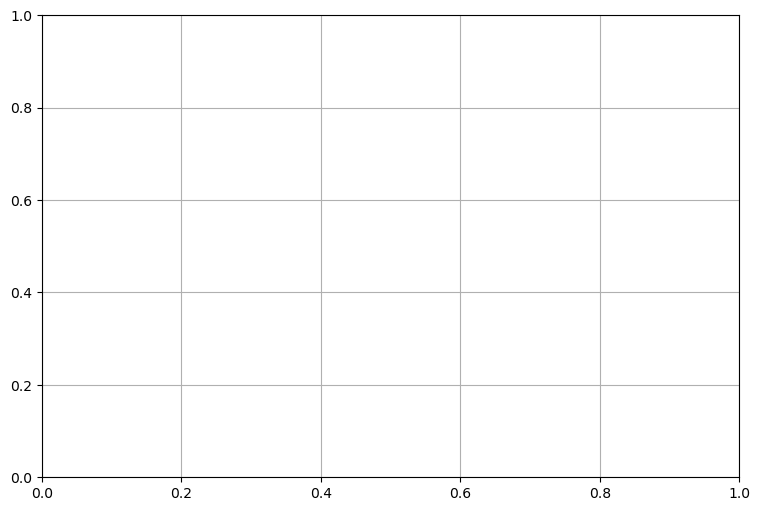

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import enum
import scipy.integrate as integrate
from scipy.stats import norm
import scipy as sp

from tqdm import tqdm
colors = plt.get_cmap('Set2').colors
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=colors)
plt.rcParams["figure.figsize"] = (9,6)

from scipy import integrate
from scipy.integrate import quad  # Module d'intégration "quad"
plt.grid(True)



<h3> Calculation of FVA under Wrong Way Risk  : </h3> 

On this notebook, we will follow the the framework of the article [Efficient Wrong-Way Risk Modelling for Funding Valuation Adjustments](https://arxiv.org/pdf/2209.12222).

Here we set the formulas to derive the FVA :

\begin{align}
   FVA_t = FCA_t + FBA_t \\
   FCA_t  = \mathbb{E}^{Q} [\int_{t}^{T} e^{-\int_{t}^u \lambda_s^C + r_s ds} s_u^B (V_u)^+ du | \mathcal{F}_t] \\
   FBA_t =  \mathbb{E}^{Q} [\int_{t}^{T} e^{-\int_{t}^u \lambda_s^C + r_s ds} s_u^L (V_u)^- du | \mathcal{F}_t]
\end{align}

Where :

- $s^B$ stands for the $\textbf{borrow}$ spread
- $s^L$ stands for the $\textbf{lend}$ spread



Assuming that $s^L=0$, and focussing on the borrowing spread, we hav ethefore $FVA_t = FCA_t$ and we can write the following :
\begin{align}
    FVA(t) = \mathbb{E}^{Q} [\int_{t}^{T} e^{-\int_{t}^u \lambda_s^C + r_s ds} s_u^B (V_u)^+ du | \mathcal{F}_t] = \mathbb{E}^{Q} [\int_{t}^{t} EPE_{FVA}(t,u) du] \notag \\
    EPE_{FVA}(t,u) = \mathbb{E}^{Q} [e^{-\int_{t}^u \lambda_s^C + r_s ds} s_u^B (V_u)^+ | \mathcal{F}_t] \notag 
\end{align}

The idea now of the article is to decompose $EPE_{FVA}(t,u)$ into 2 composants : one characterizing the independance of the risk factors and the other taking account the WWR.

It is shown in the article that we can derive the following $\textbf{(Assuming Deterministic Funding Spreads and no CCR for the bank)}$ :


\begin{align}
   EPE_{FVA}(t,u) = EPE^{No WWR}_{FVA}(t,u) + EPE^{WWR}_{FVA}(t,u) \\
   EPE^{No WWR}_{FVA}(t,u) = \mathbb{E}^{Q}[e^{-\int_t^u \lambda_s^C ds}| \mathcal{F}_t] \mu_S(t,u) \mathbb{E}^{Q} [ e^{-\int_{t}^u  r_s ds} (V_u)^+  | \mathcal{F}_t] \\
   EPE^{WWR}_{FVA}(t,u) =  s^b(u) \mathbb{E}^{Q}_t [(e^{-\int_{t}^{u} r_u du} (V_u)^+ - \mathbb{E}^{Q}_t[e^{-\int_{t}^{u} r_u du} (V_u)^+] ) e^{-\int_{t}^{u} \lambda_C(s) ds}]
\end{align}

We will calculate in the following the value for $FVA_0$ for Different Type of Products to illustrate this concept.

<h3> A Forward Contract in the BS Model :  </h3>

In [6]:

N = norm.cdf

def BS_CALL(S, K, t, T, r, sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*(T-t)) / (sigma*np.sqrt(T-t))
    d2 = d1 - sigma * np.sqrt(T-t)
    return S * N(d1) - K * np.exp(-r*(T-t))* N(d2)


def BS_Forward(S,K,t,T,r):
    return S - K*np.exp(-r*(T-t))

In [2]:
def FVAComputationBS(NbrPaths,NbrSteps,T,rho):
     
    
    # Setting Parameters
    
    
    dt= T / NbrSteps
    kappalambd=0.35
    thetalambd=0.12
    sigmalambd=0.12
    lambda0=0.12
    
    
    # BS Diffusion Parameters
    S0=100
    r=0.03
    sigma=0.2
    K=100
    
    # We define a CDS Discount curve (obtained from the market)
    Gfunc  = lambda t : CIR_ZCB(kappalambd,sigmalambd,thetalambd,0,t,lambda0)
    h      = lambda t : -(np.log(Gfunc(t+dt) ) - np.log(Gfunc(t-dt))) / (2*dt)

    
    # Defining Fitting Curve to Initial ZCBondsIntensity
    #theta = lambda t: 1.0/lambd * (hfunc(t+dt)-hfunc(t-dt))/(2.0*dt) + hfunc(t) + \
    #sigma*sigma/(2.0*lambd*lambd)*(1.0-np.exp(-2.0*lambd*t))
    
    
    
    # Defining the Correlation Parameter
    mean= [0,0]
    cov=[[1,rho],[rho,1]]
    
    
    
    
    S=np.ones(([NbrPaths, NbrSteps]))
    Survival=np.ones(([NbrPaths, NbrSteps]))
    λ=np.zeros(([NbrPaths,NbrSteps]))
    
    
    etacallWWR=np.zeros(([NbrPaths,NbrSteps]))
    etacallNoWWR=np.zeros(([NbrPaths,NbrSteps]))
    etaforwardWWR=np.zeros(([NbrPaths,NbrSteps]))
    etaforwardNoWWR=np.zeros(([NbrPaths,NbrSteps]))
    
    S[:,0]=  S0
    λ[:,0]=lambda0

    EECallWWR=np.zeros(([NbrSteps]))
    EECallNoWWR=np.zeros(([NbrSteps]))
    EEForwardWWR=np.zeros(([NbrSteps]))
    EEForwardNoWWR=np.zeros(([NbrSteps]))
        
    for i in range(1,NbrSteps): 
        current_t=float(i*dt)
        WT=np.random.multivariate_normal(mean,cov,NbrPaths)*np.sqrt(dt)
         
        
        S[:,i] = S[:,i-1] + S[:,i-1] * (r*dt + sigma *WT[:,0])
        λ[:,i]=λ[:,i-1] + kappalambd*(thetalambd-np.maximum(λ[:,i-1],0.0)) *dt +sigmalambd*np.sqrt(np.maximum(λ[:,i-1],0.0))*WT[:,1]
        Survival[:,i]=Survival[:,i-1]*np.exp(-(λ[:,i]+λ[:,i-1])*0.5*dt)
    
    
    FVACallNoWWR=0
    FVACallWWR=0
    FVACall = 0
    FVAForwardNoWWR=0
    FVAForwardWWR=0
    FVAForward = 0
    spread_borrow=0.02

    
    for j in tqdm(range(NbrSteps)):
        current_t=float(j*dt)
        current_pricecall=np.zeros((NbrPaths))
        current_priceforward=np.zeros((NbrPaths))
        for sample in range(NbrPaths):
            current_S=S[sample,j]
            pricecall=BS_CALL(current_S,K,current_t,T,r,sigma)
            priceforward=BS_Forward(current_S,K,current_t,T,r)
            current_pricecall[sample]=pricecall
            current_priceforward[sample]=priceforward
        
        #etacallNoWWR[:,j]=Gfunc(current_t) * spread_borrow * np.exp(-r*current_t) * (current_pricecall)
        Expectation = np.mean(np.exp(-r*current_t) * current_pricecall)
        etacallWWR[:,j] = spread_borrow * (np.exp(-r*current_t) * current_pricecall - Expectation) * Survival[:,j]
       
        
    
        EECallWWR[j]=np.mean(etacallWWR[:,j])
        EECallNoWWR[j]=Gfunc(current_t) * spread_borrow * BS_CALL(S0,K,0,T,r,sigma)
        
        etaforwardWWR[:,j]=np.exp(-r*current_t) * (np.maximum(current_priceforward,0)*λ[:,j]*Survival[:,j]) / (h(current_t) * Gfunc(current_t))
        etaforwardNoWWR[:,j]=np.exp(-r*current_t) * (np.maximum(current_priceforward,0))
        
        etaforwardNoWWR[:,j]=Gfunc(current_t) * spread_borrow * np.exp(-r*current_t) * (np.maximum(current_priceforward,0.0))
        Expectation = np.mean(np.exp(-r*current_t) * np.maximum(current_priceforward,0.0))
        etaforwardWWR[:,j] = spread_borrow * (np.exp(-r*current_t) * np.maximum(current_priceforward,0.0) - Expectation) * Survival[:,j]

        EEForwardWWR[j]=np.mean(etaforwardWWR[:,j])
        EEForwardNoWWR[j]=np.mean(etaforwardNoWWR[:,j])
        
        FVACallNoWWR   +=  EECallNoWWR[j] * dt
        FVACallWWR += EECallWWR[j] * dt
        FVACall +=  (EECallNoWWR[j] + EECallWWR[j] ) * dt
        FVAForwardNoWWR += EEForwardNoWWR[j] * dt
        FVAForwardWWR += EEForwardWWR[j]*dt
        FVAForward += (EEForwardNoWWR[j] + EEForwardWWR[j])* dt
        #print(EE[j])
        
        
    
        
    # Outputs
    return λ,S,EECallWWR,EECallNoWWR,EEForwardWWR,EEForwardNoWWR,FVACallNoWWR,FVACallWWR,FVACall,FVAForwardNoWWR,FVAForwardWWR,FVAForward



  0%|                                                                                           | 0/50 [00:00<?, ?it/s]


KeyboardInterrupt: 

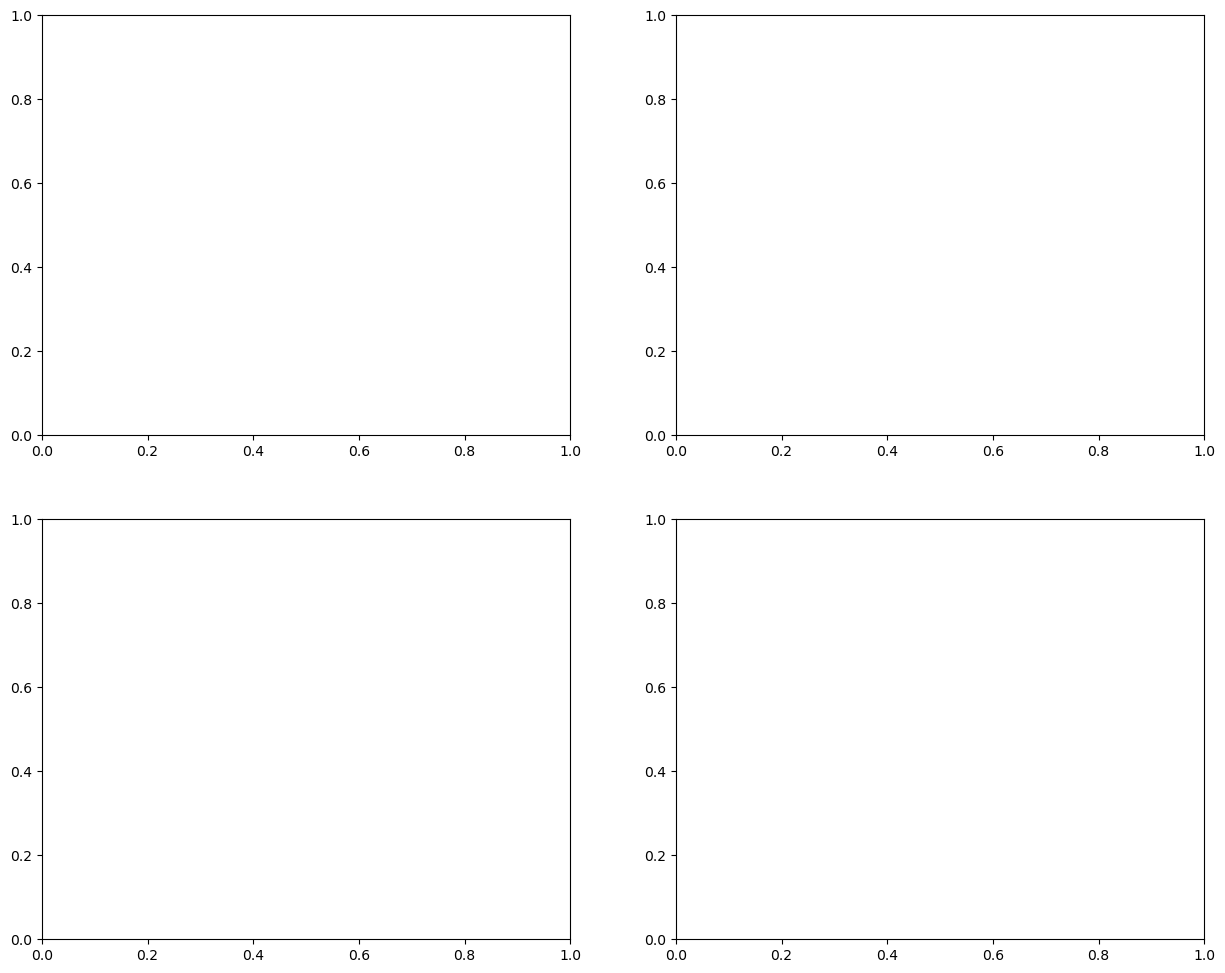

In [8]:
NbrSteps=50
NbrPaths=50000
T=1
rhoVec=[-0.9,-0.5,0,0.5, 0.9]



#
EEValueCallWWR=[]
EEValueCallNoWWR=[]
EEValueForwardWWR=[]
EEValueForwardNoWWR=[]
FVAValueCallWWR=[]
FVAValueCallNoWWR=[]
FVAValueForwardWWR=[]
FVAValueForwardNoWWR=[]
time=np.linspace(0,T,NbrSteps)

#EEForward,CVAForward
fig, ax = plt.subplots(2, 2, figsize=(15, 12))

for rho in rhoVec:
    λ,S,EECallWWR,EECallNoWWR,EEForwardWWR,EEForwardNoWWR,FVACallNoWWR,FVACallWWR,FVACall,FVAForwardNoWWR,FVAForwardWWR,FVAForward=FVAComputationBS(NbrPaths,NbrSteps,T,rho)
    EEValueCallWWR.append(EECallWWR)
    EEValueCallNoWWR.append(EECallNoWWR)
    EEValueForwardWWR.append(EEForwardWWR)
    EEValueForwardNoWWR.append(EEForwardNoWWR)
    FVAValueCallWWR.append(FVACallWWR)
    FVAValueCallNoWWR.append(FVACallNoWWR)
    FVAValueForwardWWR.append(FVAForwardWWR)
    FVAValueForwardNoWWR.append(FVAForwardNoWWR)
    ax[0][0].plot(time,EECallWWR,label="Rho = " + str(rho))
    ax[1][0].plot(time,EEForwardWWR,label="Rho = "+str(rho))

    
#
ax[0][0].set_title("$EE^{FVA}_{WWR}$ Profile for a Call Option under B-S Model")
ax[0][0].set_xlabel("Time")
ax[0][0].set_ylabel("EE Profile")
ax[0][0].legend(loc="upper left")
ax[0][0].grid()

ax[1][0].set_title("$EE^{FVA}_{WWR}$ Profile for a Forward Contract under B-S Model")
ax[1][0].set_xlabel("Time")
ax[1][0].set_ylabel("EE Profile")
ax[1][0].legend(loc="upper left")
ax[1][0].grid()

#
ax[0][1].plot(rhoVec,FVAValueCallWWR,label="FVA WWR")
ax[0][1].plot(rhoVec,FVAValueCallNoWWR,label="FVA No WWR")
ax[0][1].plot()
ax[0][1].set_title("FVA of a Call Option as a function of Rho")
ax[0][1].set_xlabel("Rho")
ax[0][1].set_ylabel("FVA")
ax[0][1].legend(loc="upper right")
ax[0][1].grid()


ax[1][1].plot(rhoVec,FVAValueForwardWWR,label="FVA WWR")
ax[1][1].plot(rhoVec,FVAValueForwardNoWWR,label="FVA No WWR")
ax[1][1].set_title("FVA of a Forward Contract as a function of Rho")
ax[1][1].set_xlabel("Rho")
ax[1][1].set_ylabel("FVA")
ax[1][1].legend(loc="upper right")
ax[1][1].grid()

plt.legend()


    

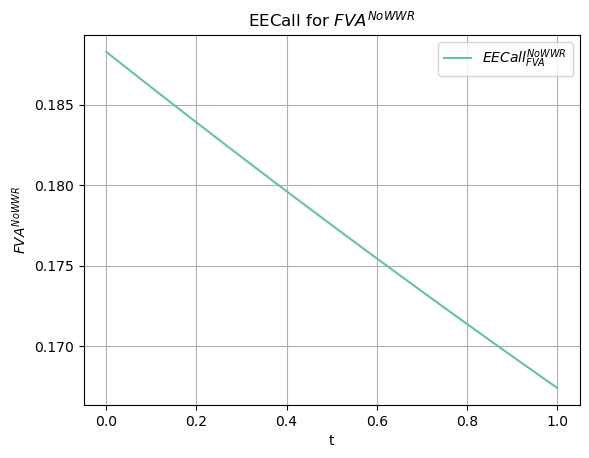

In [146]:
plt.plot(time,EECallNoWWR,label="$EECall_{FVA}^{No WWR}$")
plt.xlabel("t")
plt.ylabel("$FVA^{No WWR}$")
plt.title("EECall for $FVA^{No WWR}$")
plt.legend()
plt.grid()

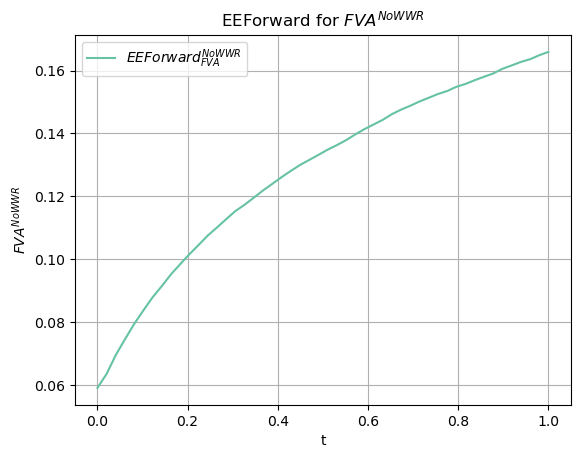

In [147]:
plt.plot(time,EEForwardNoWWR,label="$EEForward_{FVA}^{No WWR}$")
plt.xlabel("t")
plt.ylabel("$FVA^{No WWR}$")
plt.title("EEForward for $FVA^{No WWR}$")
plt.legend()
plt.grid()

In [148]:
g = lambda x,y : x/y
f = lambda x,y : x+y

In [149]:
FVAValueForwardNoWWR + FVAValueForwardWWR

FVAValueCall= [f(x,y) for (x,y) in zip(FVAValueCallNoWWR,FVAValueCallWWR)]
FVAValueForward= [f(x,y) for (x,y) in zip(FVAValueForwardNoWWR,FVAValueForwardWWR)]

FVARatioCallVec=  [g(x,y) for x,y in zip(FVAValueCall,FVAValueCallNoWWR)]
FVARatioForwardVec= [g(x,y) for x,y in zip(FVAValueForward,FVAValueForwardNoWWR)]

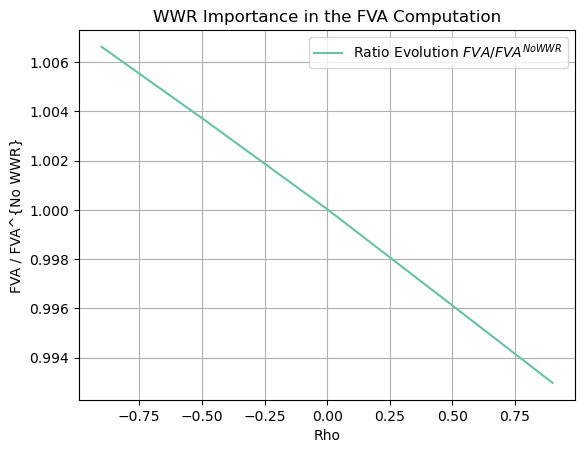

In [150]:
plt.plot(rhoDefault,FVARatioCallVec,label="Ratio Evolution $ FVA / FVA^{No WWR} $")
plt.legend()
plt.xlabel("Rho")
plt.ylabel("FVA / FVA^{No WWR}")
plt.title("WWR Importance in the FVA Computation")
plt.grid()

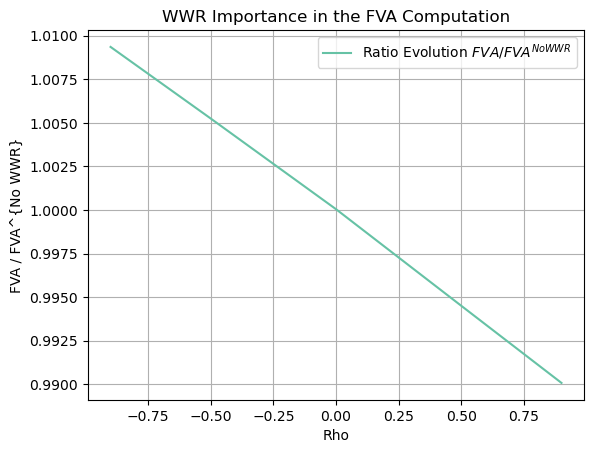

In [151]:
plt.plot(rhoDefault,FVARatioForwardVec,label="Ratio Evolution $ FVA / FVA^{No WWR} $")
plt.legend()
plt.xlabel("Rho")
plt.ylabel("FVA / FVA^{No WWR}")
plt.title("WWR Importance in the FVA Computation")
plt.grid()

<h3> A Call Option in the BS Model : </h3>

In [ ]:
ax[0][0].set_title("EE Profile for a Call Option under B-S Model")
ax[0][0].set_xlabel("Time")
ax[0][0].set_ylabel("EE Profile")
ax[0][0].legend(loc="upper left")


ax[1][0].set_title("EE Profile for a Forward Contract under B-S Model")
ax[1][0].set_xlabel("Time")
ax[1][0].set_ylabel("EE Profile")
ax[1][0].legend(loc="upper left")
#
ax[0][1].plot(rhoVec,FVAValueCallWWR,label="FVA WWR")
ax[0][1].plot(rhoVec,FVAValueCallNoWWR,label="FVA No WWR")
ax[0][1].plot()
ax[0][1].set_title("CVA of a Call Option as a function of Rho")
ax[0][1].set_xlabel("Rho")
ax[0][1].set_ylabel("VA")
ax[0][1].legend(loc="upper right")

ax[1][1].plot(rhoVec,FVAValueForwardWWR,label="FVA WWR")
ax[1][1].plot(rhoVec,FVAValueForwardNoWWR,label="FVA No WWR")
ax[1][1].set_title("FVA of a Forward Contract as a function of Rho")
ax[1][1].set_xlabel("Rho")
ax[1][1].set_ylabel("FVA")
ax[1][1].legend(loc="upper right")

plt.legend()

<h3> An Interest Rate in the G2++ Model :  </h3>


In [3]:
def generate_G2_pathsAndIntensity(NbrPaths,NbrSteps,T,P0T,kappax,kappay,sigmax,sigmay,rhoAsset,rhoDefault):
    
    # Intensity Parameters
    
    kappalambd=0.35
    thetalambd=0.12
    sigmalambd=0.12
    lambda0=0.12
    dt = T / float(NbrSteps)
    forward = lambda t: -(np.log(P0T(t+dt)) - np.log(P0T(t -dt)))/(2*dt)
    r0 = forward(0.00001)
    phi = lambda t:  forward(t) + sigmax*sigmax / (2*kappax*kappax) *pow(1-np.exp(-kappax*t),2) + sigmay*sigmay / ( 2*kappay*kappay) * pow(1-np.exp(-kappay*t),2) + rhoAsset*sigmax*sigmay / (kappax*kappay) * (1-np.exp(-kappax*t))*(1-np.exp(-kappay*t))
    dt = T / float(NbrSteps)
    mean= [0,0]
    cov=[[1,rhoAsset],[rhoAsset,1]]
    R = np.zeros([NbrPaths, NbrSteps+1])
    x = np.zeros([NbrPaths, NbrSteps+1])
    y= np.zeros([NbrPaths, NbrSteps+1])
    S=np.ones(([NbrPaths, NbrSteps+1]))
    Survival=np.ones(([NbrPaths, NbrSteps+1]))
    λ=np.zeros(([NbrPaths,NbrSteps+1]))
    time = np.zeros([NbrSteps+1])
    
    
    R[:,0]=r0
    λ[:,0]=lambda0
    
    
    #coeff = np.sqrt(0.5 * (rhoDefault ** 2 ) / ( 1+ rhoAsset))
    
    for i in range(0,NbrSteps):
        Gaussian=np.random.multivariate_normal(mean,cov,NbrPaths)
        x[:,i+1]=x[:,i] * (1- kappax*dt) + sigmax * np.sqrt(dt) * Gaussian[:,0]
        y[:,i+1]=y[:,i] * (1-kappay*dt) +  sigmay *  np.sqrt(dt) * Gaussian[:,1]
        time[i+1] = time[i] +dt
        R[:,i+1] = x[:,i+1] + y[:,i+1]+ phi(time[i+1])
        λ[:,i+1]=λ[:,i] + kappalambd*(thetalambd-np.maximum(λ[:,i],0.0)) *dt +sigmalambd*np.sqrt(np.maximum(λ[:,i],0.0))*np.sqrt(dt) * (rhoDefault * Gaussian[:,0] + np.sqrt((1- rhoDefault**2)) * np.random.normal(0,1,NbrPaths))
        Survival[:,i+1]=Survival[:,i]*np.exp(-(λ[:,i+1]+λ[:,i])*0.5*dt)
        
    # Outputs
    return time, R,x,y,λ,Survival

                                                                       
  

100%|█████████████████████████████████████████████████████████████████████████████| 501/501 [00:00<00:00, 10026.94it/s]


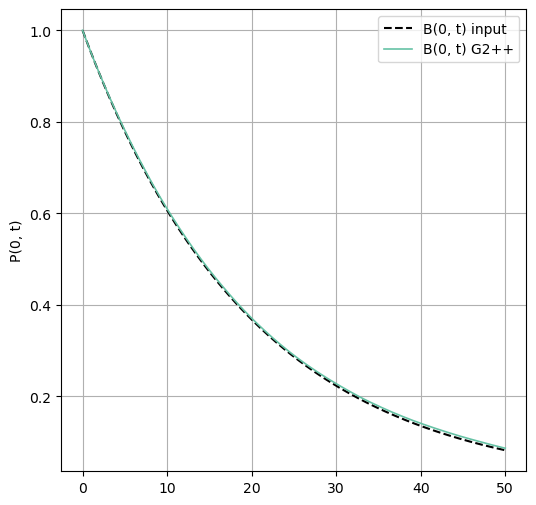

In [4]:
def ZCB_sanity_check(NoOfPaths, NoOfSteps):
    T         = 50.0
    kappax     = 0.1
    kappay = 0.1
    sigmax=0.05
    sigmay = 0.02
    rhoAsset=-0.99
    rhoDefault=0.9
    dt = T / float(NoOfSteps)
    
    # We define a ZCB curve (obtained from the market)
    P0T = lambda T: np.exp(-0.05*T) 
    fig, ax = plt.subplots(1, 1, figsize = (6, 6))  
    time, R,x,y,λ,Survival = generate_G2_pathsAndIntensity(NoOfPaths,NoOfSteps,T,P0T,kappax,kappay,sigmax,sigmay,rhoAsset,rhoDefault)
    M = np.zeros([NoOfPaths, NoOfSteps+1])
    M[:,0]= 1.0
    for i in tqdm(range(0, NoOfSteps)):
        #money saving account:  dM(t)=rM(t)dt is M(t)=M(t_0)exp(int_0^tr(t)dt)
        M[:,i+1] = M[:,i] * np.exp((R[:,i+1]+R[:,i])*0.5*dt) #Tripazoides method
    Pmdl=  np.zeros([NoOfSteps+1])
    for i in tqdm(range(0,NoOfSteps+1)):
        Pmdl[i] = np.mean(1.0/M[:,i])
    ax.plot(time,(P0T(time)),"--k", label = "B(0, t) input")
    ax.plot(time, Pmdl, linewidth = "1.2", label = "B(0, t) G2++")
    ax.set_ylabel("P(0, t)")
    ax.grid()
    plt.legend()
    plt.show()
    #fig.savefig("G2++_ZCB.png")
ZCB_sanity_check (20000, 500)

In [5]:
class OptionTypeSwap(enum.Enum):
    RECEIVER = 1.0
    PAYER = -1.0


def V(kappax,kappay,sigmax,sigmay,rho,T1,T2):
    facteur1=pow(sigmax,2)/pow(kappax,2)
    facteur2=pow(sigmay,2)/pow(kappay,2)
    kappa=kappax+kappay
    facteur3=(2*rho*sigmax*sigmay)/(kappax*kappay)
    
    first=facteur1*(T2-T1+ 2*np.exp(-kappax*(T2-T1))/(kappax)-(np.exp(-2*kappax*(T2-T1)))/(2*kappax)-3/(2*kappax))
    #print(first)
    second=facteur2*(T2-T1+ 2*np.exp(-kappay*(T2-T1))/(kappay)-(np.exp(-2*kappay*(T2-T1)))/(2*kappay)-3/(2*kappay))
    #print(second)
    third=facteur3*(T2-T1+(np.exp(-kappax*(T2-T1))-1)/(kappax)+(np.exp(-kappay*(T2-T1))-1)/(kappay)-(np.exp(-kappa*(T2-T1))-1)/(kappa))
    #print(third)
    return first+second+third


def G2_ZCB(kappax,kappay,sigmax,sigmay,rho,P0T,T1,T2,xT1,yT1):
    
    n = np.size(xT1) 
        
    if T1<T2:
        first_factor=P0T(T2) / P0T(T1)
        #first_factor=(-1/(T2-T1))  *np.log(P0T(T2)/P0T(T1))
        second_factor = 1/2 * (V(kappax,kappay,sigmax,sigmay,rho,T1,T2) -V(kappax,kappay,sigmax,sigmay,rho,0,T2) +V(kappax,kappay,sigmax,sigmay,rho,0,T1))
        third_factor= ((1-np.exp(-kappax*(T2-T1)))*xT1) / (kappax) + ((1-np.exp(-kappay*(T2-T1)))*yT1) / (kappay)
        return first_factor*np.exp(second_factor-third_factor)
    else:
        return np.ones([n])

def G2_SwapPrice(CP,notional,K,t,Ti,Tm,n,x_t,y_t,P0T,kappax,kappay,sigmax,sigmay,rho):
    # CP- payer of receiver
    # n- notional
    # K- strike
    # t- today's date
    # Ti- beginning of the swap
    # Tm- end of Swap
    # n- number of dates payments between Ti and Tm
    # r_t -interest rate at time t

    if n == 1:
        ti_grid =np.array([Ti,Tm])
    else:
        ti_grid = np.linspace(Ti,Tm,n)
    tau = ti_grid[1]- ti_grid[0]
    
    # overwrite Ti if t>Ti
    prevTi = ti_grid[np.where(ti_grid<t)]
    if np.size(prevTi) > 0: #prevTi != []:
        Ti = prevTi[-1]
    
    # Now we need to handle the case when some payments are already done
    ti_grid = ti_grid[np.where(ti_grid>t)]          

    temp= np.zeros(np.size(x_t));
    
    P_t_TiLambda = lambda Ti : G2_ZCB(kappax,kappay,sigmax,sigmay,rho,P0T,t,Ti,x_t,y_t)
    
    for (idx,ti) in enumerate(ti_grid):
        if ti>Ti:
            temp = temp + tau * P_t_TiLambda(ti)
            
    P_t_Ti = P_t_TiLambda(Ti)
    P_t_Tm = P_t_TiLambda(Tm)
    
    if CP==OptionTypeSwap.PAYER:
        swap = (P_t_Ti - P_t_Tm) - K * temp
    elif CP==OptionTypeSwap.RECEIVER:
        swap = K * temp- (P_t_Ti - P_t_Tm)
    
    return swap*notional


# A Revoir : 
#def G2_SwaptionPrice(CP,notional,K,t,Ti,Tm,n,x_t,y_t,P0T,kappax,kappay,sigmax,sigmay,rho):
#    swap_price=G2_SwapPrice(CP,notional,K,t,Ti,Tm,n,x_t,y_t,P0T,kappax,kappay,sigmax,sigmay,rho)
#    payoff=np.maximum(swap_price,0)
#    return np.mean(payoff)*np.exp(-



\begin{align}
   EPE_{FVA}(t,u) = EPE^{No WWR}_{FVA}(t,u) + EPE^{WWR}_{FVA}(t,u) \\
   EPE^{No WWR}_{FVA}(t,u) = \mathbb{E}^{Q}[e^{-\int_t^u \lambda_s^C ds}| \mathcal{F}_t] \mu_S(t,u) \mathbb{E}^{Q} [\int_{t}^{T} e^{-\int_{t}^u  r_s ds} (V_u)^+ du | \mathcal{F}_t] \\
   EPE^{WWR}_{FVA}(t,u) =  s_b(u) \mathbb{E}^{Q}_t [(e^{-\int_{t}^{u} r_u du} (V_u)^+ - \mathbb{E}^{Q}_t[e^{-\int_{t}^{u} r_u du} (V_u)^+] ) e^{-\int_{t}^{u} \lambda_C(s) ds}]
\end{align}

In [11]:
# CIR Modelling

def ACIR(kappa,sigma,theta,T1,T2):
    h=np.sqrt(pow(kappa,2) + 2 * pow(sigma,2))
    BCIRValue=BCIR(kappa,sigma,theta,T1,T2)
    tau=T2-T1
    return pow((h*np.exp(0.5*tau * (kappa+h))*BCIRValue)/ (np.exp(h*tau) - 1), 2*kappa*theta / sigma**2)

def BCIR(kappa,sigma,theta,T1,T2):
    h=np.sqrt(pow(kappa,2) + 2 * pow(sigma,2))
    tau=T2-T1
    numerator=np.exp(h*tau) - 1
    denominator =  h + 0.5*(kappa+h)*(np.exp(h*tau)-1)
    return numerator / denominator


def CIR_ZCB(kappa,sigma,theta,T1,T2,rT1):
    
    if T1==T2:
        return 1
    else:
        B_r=BCIR(kappa,sigma,theta,T1,T2)
        A_r=ACIR(kappa,sigma,theta,T1,T2)
        return A_r * np.exp(-B_r * rT1)
    


In [12]:
def FVAComputationSwap(rhoAsset,rhoDefault):
     
    
    # Setting Parameters
    NoOfPaths = 50000
    NoOfSteps = 1000
    kappax     = 0.6
    kappay = 0.15
    sigmax=0.06
    sigmay = 0.04
    notional  = 10000.0 
    kappalambd=0.35
    thetalambd=0.12
    sigmalambd=0.12
    lambda0=0.12

    
    
 

    
    # We define a CDS Discount curve (obtained from the market)
    Gfunc  = lambda t : CIR_ZCB(kappalambd,sigmalambd,thetalambd,0,t,lambda0)
    h      = lambda t : -(np.log(Gfunc(t+dt) ) - np.log(Gfunc(t-dt))) / (2*dt)
    P0T = lambda T: np.exp(-0.01*T)
    # We define a ZCB curve (obtained from the market)
    N = 25
    T_end = 50
    Tgrid= np.linspace(0,T_end,N)   
    # Here we simulate the exposure profiles for a swap, using the HW model    
    # Swap settings
    K = 0.01  # strike
    Ti = 1.0  # begining of the swap
    Tm = 30.0 # end date of the swap 
    n = 10    # number of payments between Ti and Tm
    timeGrid, r,x,y,λ,Survival = generate_G2_pathsAndIntensity(NoOfPaths,NoOfSteps,Tm+1.0 ,P0T, kappax,kappay,sigmax,sigmay,rhoAsset,rhoDefault)
    dt = timeGrid[1]-timeGrid[0]  
    
    
    # FVA Parameters Defining
    FVA=0
    FVANoWWR=0
    FVAWWR = 0
    spread_borrow=0.02
    #Money saving account
    M_t = np.zeros([NoOfPaths,NoOfSteps])  
    for i in range(0,NoOfPaths):
        M_t[i,:] = np.exp(np.cumsum(r[i,0:-1])*dt)
    Value= np.zeros([NoOfPaths,NoOfSteps+1])
    ENoWWR  = np.zeros([NoOfPaths,NoOfSteps+1])
    EENoWWR = np.zeros([NoOfSteps+1])
    EWWR= np.zeros([NoOfPaths,NoOfSteps+1])
    EEWWR= np.zeros([NoOfSteps+1])
    for (idx, ti) in enumerate(timeGrid[0:-2]):
        V = G2_SwapPrice(OptionTypeSwap.PAYER,notional,K,timeGrid[idx],Ti,Tm,n,x[:,idx],y[:,idx],P0T,kappax,kappay,sigmax,sigmay,rhoAsset)
        Value[:,idx] = V
        ENoWWR[:,idx] = Gfunc(ti)*spread_borrow*(np.maximum(V,0.0))
        Expectation = np.mean(np.maximum(V,0.0) / M_t[:,idx])
        EWWR[:,idx]=spread_borrow * (np.maximum(V,0.0) / (M_t[:,idx]) - Expectation)* Survival[:,idx]
        EENoWWR[idx] = np.mean(ENoWWR[:,idx]/M_t[:,idx])
        EEWWR[idx]=np.mean(EWWR[:,idx])
        
        #fig, ax = plt.subplots(1, 2, figsize = (15, 6))
        #ax[0].plot(timeGrid,Value[0:100,:].transpose(),linewidth ="0.3" )
        #ax[0].grid()
        #ax[0].set_xlabel('time t')
        #ax[0].set_ylabel('Swap Value(t)')
        #ax[0].set_title('Value of a swap')    
        #ax[1].plot(timeGrid,EE)
        #ax[1].grid()
        #ax[1].set_xlabel('time t')
        #ax[1].set_ylabel('EE(t)')
        #ax[1].set_title('Discounted Expected (positive) exposure, EE avec rho=' + str(rho))
        #plt.show()
    
    for (idx,ti) in enumerate(timeGrid[0:-2]):
        FVANoWWR+=  EENoWWR[idx] * dt 
        FVAWWR +=   EEWWR[idx] * dt
        FVA += FVANoWWR + FVAWWR
   
 
        
        
    
        
    # Outputs
    return timeGrid,EENoWWR,EEWWR,FVANoWWR,FVAWWR,FVA


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:00<00:00, 20.08s/it]


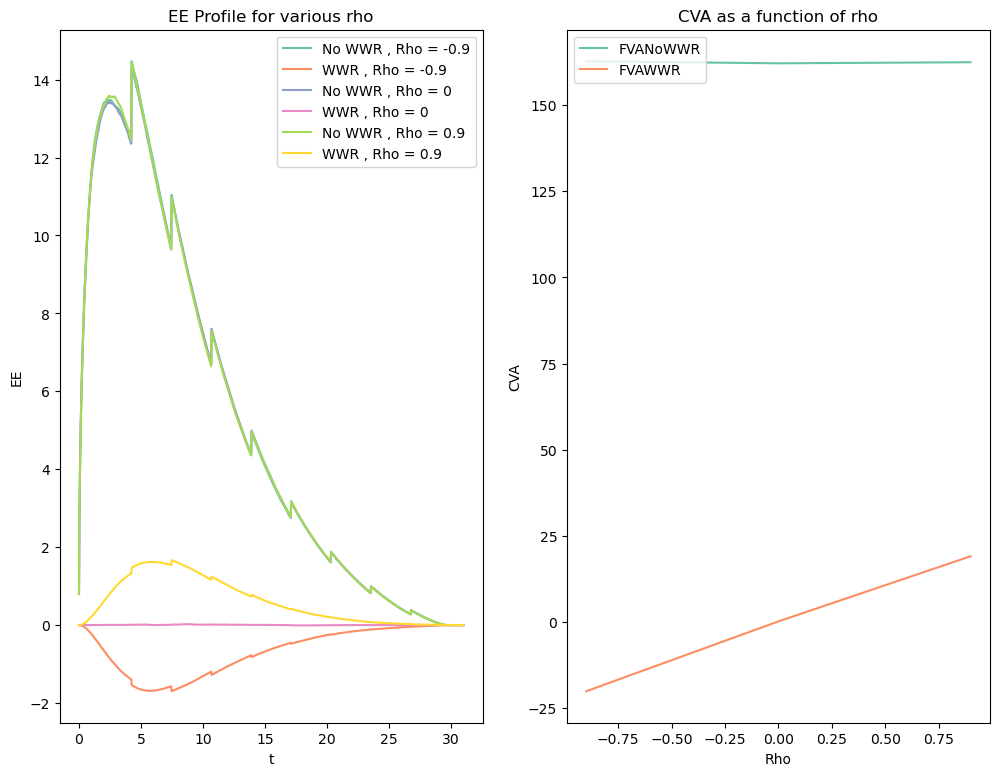

In [25]:
rhoAsset=-0.98
rhoDefault=[-0.9,0,0.9]

    
fig, ax = plt.subplots(1, 2, figsize=(12,9))

FVANoWWRVec=[]
FVAWWRVec=[]
FVAVec=[]
CVANoWWRDefault=[]
for rho in tqdm(rhoDefault):
    timeGrid,EENoWWR,EEWWR,FVANoWWR,FVAWWR,FVA=FVAComputationSwap(rhoAsset,rho)
    FVANoWWRVec.append(FVANoWWR)
    FVAWWRVec.append(FVAWWR)
    FVAVec.append(FVA)
    ax[0].plot(timeGrid,EENoWWR,label="No WWR , Rho = " + str(rho))
    ax[0].plot(timeGrid,EEWWR,label="WWR , Rho = " + str(rho))

    

    
ax[0].set_title("EE Profile for various rho")
ax[0].set_xlabel("t")
ax[0].set_ylabel("EE")
ax[0].legend(loc="upper right")

ax[1].plot(rhoDefault,FVANoWWRVec,label="FVANoWWR")
ax[1].plot(rhoDefault,FVAWWRVec,label="FVAWWR")

ax[1].set_title("CVA as a function of rho")
ax[1].set_xlabel("Rho")
ax[1].set_ylabel("CVA")
ax[1].legend(loc="upper left")


#ax[1].plot(rhoDefault,CVANoWWRDefault,label="CVA No WWR")
#ax[1].set_title("CVA as a function of rho")
#ax[1].set_xlabel("Rho")
#ax[1].set_ylabel("CVA")
#ax[1].legend(loc="upper left")



In [28]:
FVAWWRVec

[-20.15058083642452, 0.12354461029806361, 19.03033347642483]

<h3> An Interest Rate in the Hull $\&$ White Model :  </h3>


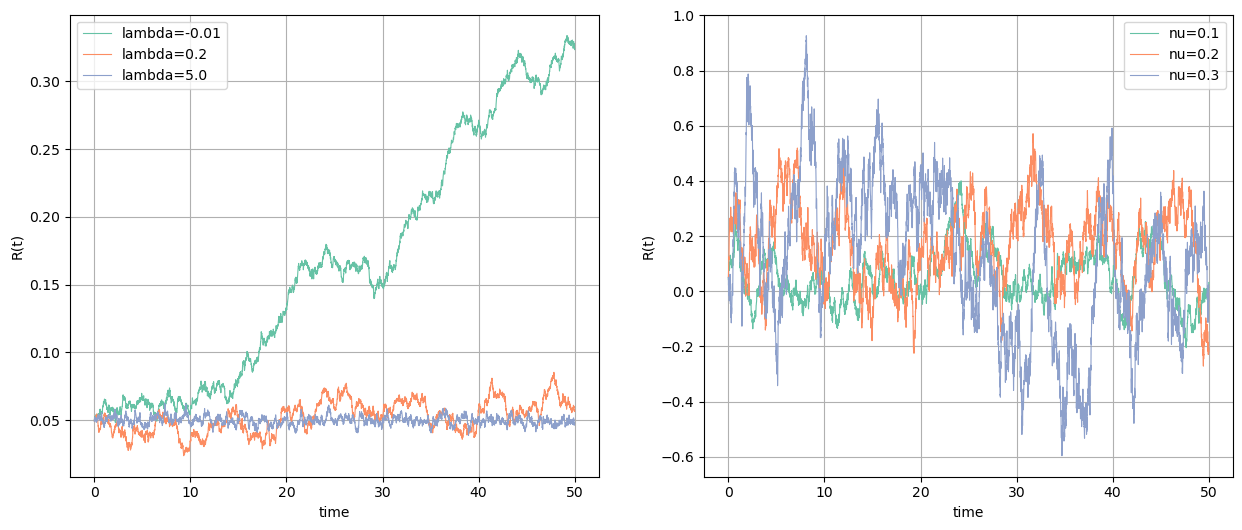

In [6]:
def generate_hW_paths(NbrPaths,NbrSteps,T,P0T, lambd, nu,rhoDefault):
    
    
    # Intensity Parameters
    
    kappalambd=0.35
    thetalambd=0.12
    sigmalambd=0.12
    lambda0=0.12
    
    dt = T / float(NbrSteps)
    forward = lambda t: -(np.log(P0T(t+dt)) - np.log(P0T(t -dt)))/(2*dt)
    r0 = forward(0.00001)
    theta = lambda t: 1.0/lambd * (forward(t+dt)-forward(t-dt))/(2.0*dt) + forward(t) + \
    nu*nu/(2.0*lambd*lambd)*(1.0-np.exp(-2.0*lambd*t))
    Z = np.random.normal(0.0,1.0,[NbrPaths,NbrSteps])
    W = np.zeros([NbrPaths, NbrSteps+1])
    R = np.zeros([NbrPaths, NbrSteps+1])
    Survival=np.ones(([NbrPaths, NbrSteps+1]))
    λ=np.zeros(([NbrPaths,NbrSteps+1]))
    time = np.zeros([NbrSteps+1])
    mean= [0,0]
    cov=[[1,rhoDefault],[rhoDefault,1]]
    R[:,0]=r0
    λ[:,0]=lambda0
        
    for i in range(0,NbrSteps):
        Gaussian=np.random.multivariate_normal(mean,cov,NbrPaths)
        time[i+1] = time[i] +dt
        R[:,i+1] = R[:,i] + lambd * (theta(time[i]) - R[:,i]) * dt + nu*np.sqrt(dt)* Gaussian[:,0]
        λ[:,i+1]=λ[:,i] + kappalambd*(thetalambd-np.maximum(λ[:,i],0.0)) *dt +sigmalambd*np.sqrt(np.maximum(λ[:,i],0.0))*np.sqrt(dt) * (rhoDefault * Gaussian[:,0] + np.sqrt(1-rhoDefault**2)*Gaussian[:,1])
        Survival[:,i+1]=Survival[:,i]*np.exp(-(λ[:,i+1]+λ[:,i])*0.5*dt)

    # Outputs
    return time, R,λ,Survival

def simulate_HW_Paths(NoOfPaths, NoOfSteps):
    T         = 50.0
    lambd     = 0.5
    nu       = 0.01
    RhoDefault=0.5
    np.random.seed(0) #for reproductibility
    
    # We define a ZCB curve (obtained from the market)
    P0T = lambda T: np.exp(-0.05*T) 

    # Effect of mean reversion lambda
    fig, ax = plt.subplots(1, 2, figsize = (15, 6))
    legend = []
    lambdVec = [-0.01, 0.2, 5.0]
    for lambdTemp in lambdVec:    
        time, R,λ,Survival= generate_hW_paths(NoOfPaths,NoOfSteps,T,P0T, lambdTemp, nu,RhoDefault)
        legend.append('lambda={0}'.format(lambdTemp))
        ax[0].plot(time, np.transpose(R), linewidth = '0.8')  
        ax[0].set_xlabel("time")
        ax[0].set_ylabel("R(t)")
    ax[0].legend(legend)
    ax[0].grid()
    # Effect of the volatility
    legend = []
    nuVec = [0.1, 0.2, 0.3]
    for nuTemp in nuVec:
        time, R,λ,Survival = generate_hW_paths(NoOfPaths,NoOfSteps,T,P0T, lambd, nuTemp,RhoDefault)
        legend.append('nu={0}'.format(nuTemp))
        ax[1].plot(time, np.transpose(R), linewidth = '0.8') 
        ax[1].set_xlabel("time")
        ax[1].set_ylabel("R(t)")
    ax[1].legend(legend)
    ax[1].grid()
    #fig.savefig("Hull_white_model_parameters.png")
    plt.show()
simulate_HW_Paths (1, 5000)

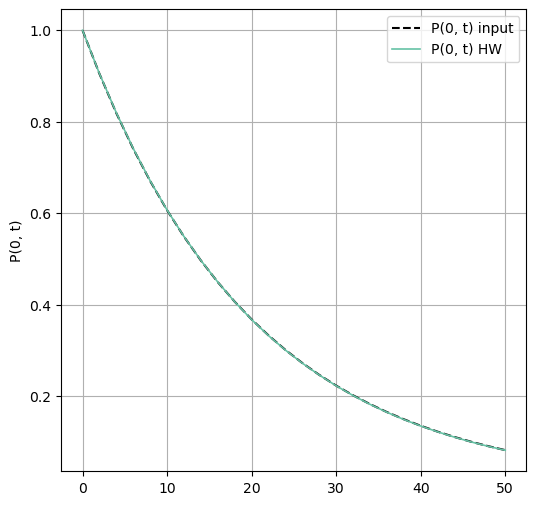

In [7]:
def ZCB_sanity_check(NoOfPaths, NoOfSteps):
    T         = 50.0
    lambd     = 0.5
    nu       = 0.01
    dt = T / float(NoOfSteps)
    RhoDefault=0.5
    
    # We define a ZCB curve (obtained from the market)
    P0T = lambda T: np.exp(-0.05*T) 
    fig, ax = plt.subplots(1, 1, figsize = (6, 6))  
    time, R,λ,Survival = generate_hW_paths(NoOfPaths,NoOfSteps,T,P0T, lambd, nu,RhoDefault)
    M = np.zeros([NoOfPaths, NoOfSteps+1])
    M[:,0]= 1.0
    for i in range(0, NoOfSteps):
        #money saving account:  dM(t)=rM(t)dt is M(t)=M(t_0)exp(int_0^tr(t)dt)
        M[:,i+1] = M[:,i] * np.exp((R[:,i+1]+R[:,i])*0.5*dt) #Tripazoides method
    Pmdl=  np.zeros([NoOfSteps+1])
    for i in range(0,NoOfSteps+1):
        Pmdl[i] = np.mean(1.0/M[:,i])
    ax.plot(time,(P0T(time)),"--k", label = "P(0, t) input")
    ax.plot(time, Pmdl, linewidth = "1.2", label = "P(0, t) HW")
    ax.set_ylabel("P(0, t)")
    ax.grid()
    plt.legend()
    plt.show()
    #fig.savefig("Hull_white_ZCB.png")
ZCB_sanity_check (2500, 25)

In [8]:
class OptionTypeSwap(enum.Enum):
    RECEIVER = 1.0
    PAYER = -1.0


def HW_theta(lambd,eta,P0T):
    dt = 0.0001    
    f0T = lambda t: - (np.log(P0T(t+dt))-np.log(P0T(t-dt)))/(2*dt)
    theta = lambda t: 1.0/lambd * (f0T(t+dt)-f0T(t-dt))/(2.0*dt) + f0T(t) + eta*eta/(2.0*lambd*lambd)*(1.0-np.exp(-2.0*lambd*t))
    #print("CHANGED THETA")
    return theta#lambda t: 0.1+t-t
    
def HW_A(lambd,eta,P0T,T1,T2):
    tau = T2-T1
    zGrid = np.linspace(0.0,tau,250)
    B_r = lambda tau: 1.0/lambd * (np.exp(-lambd *tau)-1.0)
    theta = HW_theta(lambd,eta,P0T)    
    temp1 = lambd * integrate.trapz(theta(T2-zGrid)*B_r(zGrid),zGrid)
    
    temp2 = eta*eta/(4.0*np.power(lambd,3.0)) * (np.exp(-2.0*lambd*tau)*(4*np.exp(lambd*tau)-1.0) -3.0) + eta*eta*tau/(2.0*lambd*lambd)
    
    return temp1 + temp2

def HW_B(lambd,eta,T1,T2):
    return 1.0/lambd *(np.exp(-lambd*(T2-T1))-1.0)

def HW_ZCB(lambd,eta,P0T,T1,T2,rT1):
    n = np.size(rT1) 
        
    if T1<T2:
        B_r = HW_B(lambd,eta,T1,T2)
        A_r = HW_A(lambd,eta,P0T,T1,T2)
        return np.exp(A_r + B_r *rT1)
    else:
        return np.ones([n])

def HW_SwapPrice(CP,notional,K,t,Ti,Tm,n,r_t,P0T,lambd,eta):
    # CP- payer of receiver
    # n- notional
    # K- strike
    # t- today's date
    # Ti- beginning of the swap
    # Tm- end of Swap
    # n- number of dates payments between Ti and Tm
    # r_t -interest rate at time t

    if n == 1:
        ti_grid =np.array([Ti,Tm])
    else:
        ti_grid = np.linspace(Ti,Tm,n)
    tau = ti_grid[1]- ti_grid[0]
    
    # overwrite Ti if t>Ti
    prevTi = ti_grid[np.where(ti_grid<t)]
    if np.size(prevTi) > 0: #prevTi != []:
        Ti = prevTi[-1]
    
    # Now we need to handle the case when some payments are already done
    ti_grid = ti_grid[np.where(ti_grid>t)]          

    temp= np.zeros(np.size(r_t));
    
    P_t_TiLambda = lambda Ti : HW_ZCB(lambd,eta,P0T,t,Ti,r_t)
    
    for (idx,ti) in enumerate(ti_grid):
        if ti>Ti:
            temp = temp + tau * P_t_TiLambda(ti)
            
    P_t_Ti = P_t_TiLambda(Ti)
    P_t_Tm = P_t_TiLambda(Tm)
    
    if CP==OptionTypeSwap.PAYER:
        swap = (P_t_Ti - P_t_Tm) - K * temp
    elif CP==OptionTypeSwap.RECEIVER:
        swap = K * temp- (P_t_Ti - P_t_Tm)
    
    return swap*notional

<h3> Expectation of a CIR process : </h3>


$\mathbb{E}[r_t] = r_0 e^{- \kappa t} + \theta( 1 -e^{-\kappa t})$

In [9]:
def FVAComputationSwapHW(rhoDefault):
     
    
    # Setting Parameters
    NoOfPaths = 200000
    NoOfSteps = 1000
    lambd     = 0.5
    eta       = 0.03
    notional  = 10000.0 
    kappalambd=0.35
    thetalambd=0.12
    sigmalambd=0.12
    lambda0=0.12
    RecoveryRateI=0.4 
    
    
 

    
    # We define a CDS Discount curve (obtained from the market)
    Gfunc  = lambda t : CIR_ZCB(kappalambd,sigmalambd,thetalambd,0,t,lambda0)
    h      = lambda t : -(np.log(Gfunc(t+dt) ) - np.log(Gfunc(t-dt))) / (2*dt)
    P0T = lambda T: np.exp(-0.01*T)
    # We define a ZCB curve (obtained from the market)
    N = 25
    T_end = 50
    Tgrid= np.linspace(0,T_end,N)   
    # Here we simulate the exposure profiles for a swap, using the HW model    
    # Swap settings
    K = 0.01  # strike
    Ti = 1.0  # begining of the swap
    Tm = 10.0 # end date of the swap 
    n = 10    # number of payments between Ti and Tm
    timeGrid, r,λ,Survival = generate_hW_paths(NoOfPaths,NoOfSteps,Tm+1.0 ,P0T, lambd,eta,rhoDefault)
    dt = timeGrid[1]-timeGrid[0]  
    
    
    FVA=0
    FVANoWWR=0
    FVAWWR = 0
    spread_borrow=0.02
    #Money saving account
    M_t = np.zeros([NoOfPaths,NoOfSteps])  
    for i in range(0,NoOfPaths):
        M_t[i,:] = np.exp(np.cumsum(r[i,0:-1])*dt)
    Value= np.zeros([NoOfPaths,NoOfSteps+1])
    ENoWWR  = np.zeros([NoOfPaths,NoOfSteps+1])
    EENoWWR = np.zeros([NoOfSteps+1])
    EWWR= np.zeros([NoOfPaths,NoOfSteps+1])
    EEWWR= np.zeros([NoOfSteps+1])
    for (idx, ti) in enumerate(timeGrid[0:-2]):
        V =  HW_SwapPrice(OptionTypeSwap.RECEIVER,notional,K,timeGrid[idx],Ti,Tm,n,r[:,idx],P0T,lambd,eta)
        Value[:,idx] = V
        spread_borrow = (1-RecoveryRateI) * (0.01 * np.exp(-lambd*timeGrid[idx]) + thetalambd * (1-np.exp(-lambd*timeGrid[idx])))
        ENoWWR[:,idx] = Gfunc(ti)*spread_borrow*(np.maximum(V,0.0))
        Expectation = np.mean(np.maximum(V,0.0) / M_t[:,idx])
        EWWR[:,idx]=spread_borrow * (np.maximum(V,0.0) / (M_t[:,idx]) - Expectation)* Survival[:,idx]
        EENoWWR[idx] = np.mean(ENoWWR[:,idx]/M_t[:,idx])
        EEWWR[idx]=np.mean(EWWR[:,idx])
        
        #fig, ax = plt.subplots(1, 2, figsize = (15, 6))
        #ax[0].plot(timeGrid,Value[0:100,:].transpose(),linewidth ="0.3" )
        #ax[0].grid()
        #ax[0].set_xlabel('time t')
        #ax[0].set_ylabel('Swap Value(t)')
        #ax[0].set_title('Value of a swap')    
        #ax[1].plot(timeGrid,EE)
        #ax[1].grid()
        #ax[1].set_xlabel('time t')
        #ax[1].set_ylabel('EE(t)')
        #ax[1].set_title('Discounted Expected (positive) exposure, EE avec rho=' + str(rho))
        #plt.show()
    
    for (idx,ti) in enumerate(timeGrid[0:-2]):
        FVANoWWR+=  EENoWWR[idx] * dt 
        FVAWWR +=   EEWWR[idx] * dt
        FVA += (EENoWWR[idx] + EEWWR[idx])* dt
   
 
        
        
    
        
    # Outputs
    return timeGrid,EENoWWR,EEWWR,FVANoWWR,FVAWWR,FVA

 
        
        
    
        
    # Outputs


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [09:28<00:00, 113.67s/it]


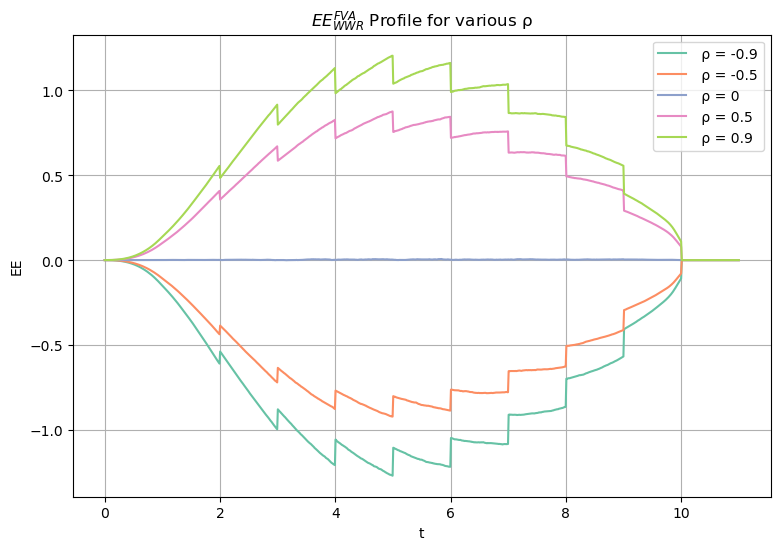

In [13]:
rhoDefault=[-0.9,-0.5,0,0.5,0.9]

    
plt.figure(figsize=(9,6))

    

FVANoWWRVec=[]
FVAWWRVec=[]
FVAVec=[]
FVARatioVec=[]
for rho in tqdm(rhoDefault):
    timeGrid,EENoWWR,EEWWR,FVANoWWR,FVAWWR,FVA=FVAComputationSwapHW(rho)
    FVANoWWRVec.append(FVANoWWR)
    FVAWWRVec.append(FVAWWR)
    FVAVec.append(FVA)
    FVARatioVec.append((FVANoWWR+FVAWWR) / FVANoWWR)
    #ax[0].plot(timeGrid,EENoWWR,label="No WWR , Rho = " + str(rho))
    plt.plot(timeGrid,EEWWR,label=" ρ = " + str(rho))

    

    
plt.title("$EE^{FVA}_{WWR}$ Profile for various ρ")
plt.xlabel("t")
plt.ylabel("EE")
plt.legend(loc="upper right")
plt.grid()

plt.savefig("EEFVAWRR.png")
#ax[1].plot(rhoDefault,FVANoWWRVec,label="FVANoWWR")
#ax[1].plot(rhoDefault,FVAWWRVec,label="FVAWWR")
#ax[1].set_title("FVA as a function of ρ")
#ax[1].set_xlabel("ρ")
#ax[1].set_ylabel("FVA")
#ax[1].legend(loc="upper left")
#ax[1].grid()

    

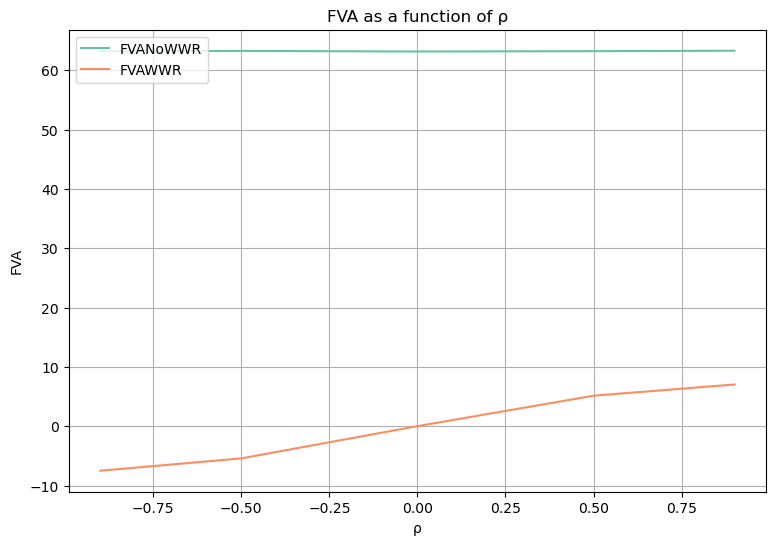

In [15]:
plt.figure(figsize=(9,6))

plt.plot(rhoDefault,FVANoWWRVec,label="FVANoWWR")
plt.plot(rhoDefault,FVAWWRVec,label="FVAWWR")
plt.title("FVA as a function of ρ")
plt.xlabel("ρ")
plt.ylabel("FVA")
plt.legend(loc="upper left")
plt.grid()

plt.savefig("FVAWWRandNoWWR.png")

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [21:26<00:00, 257.23s/it]


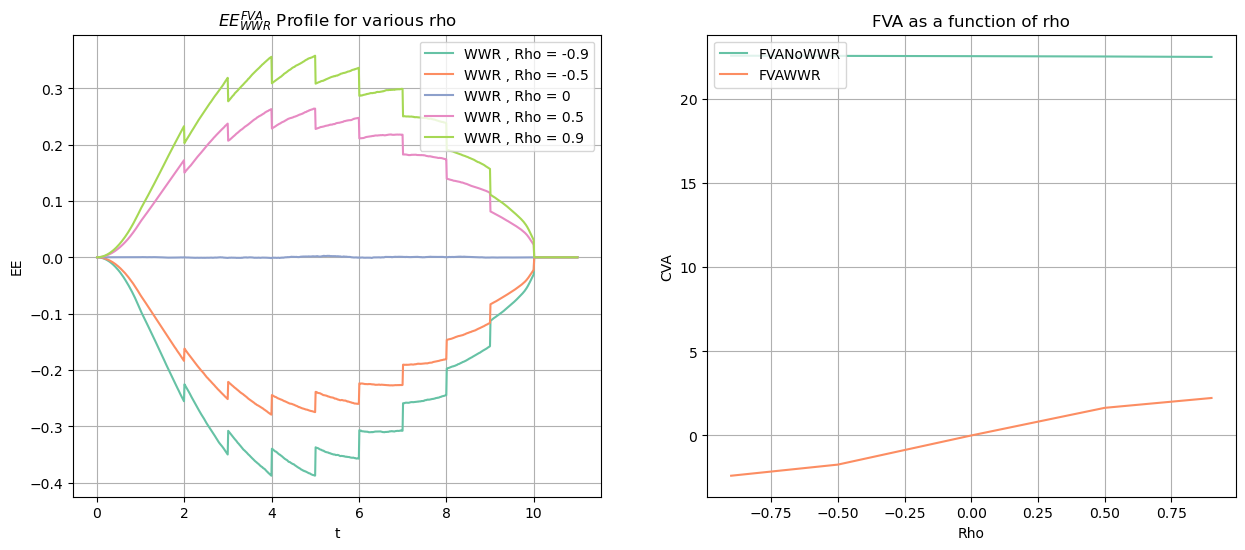

In [14]:
rhoDefault=[-0.9,-0.5,0,0.5,0.9]

    
fig, ax = plt.subplots(1, 2, figsize=(15,6))

    

FVANoWWRVec=[]
FVAWWRVec=[]
FVAVec=[]
FVARatioVec=[]
for rho in tqdm(rhoDefault):
    timeGrid,EENoWWR,EEWWR,FVANoWWR,FVAWWR,FVA=FVAComputationSwapHW(rho)
    FVANoWWRVec.append(FVANoWWR)
    FVAWWRVec.append(FVAWWR)
    FVAVec.append(FVA)
    FVARatioVec.append((FVANoWWR+FVAWWR) / FVANoWWR)
    #ax[0].plot(timeGrid,EENoWWR,label="No WWR , Rho = " + str(rho))
    ax[0].plot(timeGrid,EEWWR,label="ρ = " + str(rho))

    

    
ax[0].set_title("$EE^{FVA}_{WWR}$ Profile for various rho")
ax[0].set_xlabel("t")
ax[0].set_ylabel("EE")
ax[0].legend(loc="upper right")
ax[0].grid()
ax[1].plot(rhoDefault,FVANoWWRVec,label="FVANoWWR")
ax[1].plot(rhoDefault,FVAWWRVec,label="FVAWWR")
ax[1].set_title("FVA as a function of ρ")
ax[1].set_xlabel("ρ")
ax[1].set_ylabel("FVA")
ax[1].legend(loc="upper left")
ax[1].grid()

    

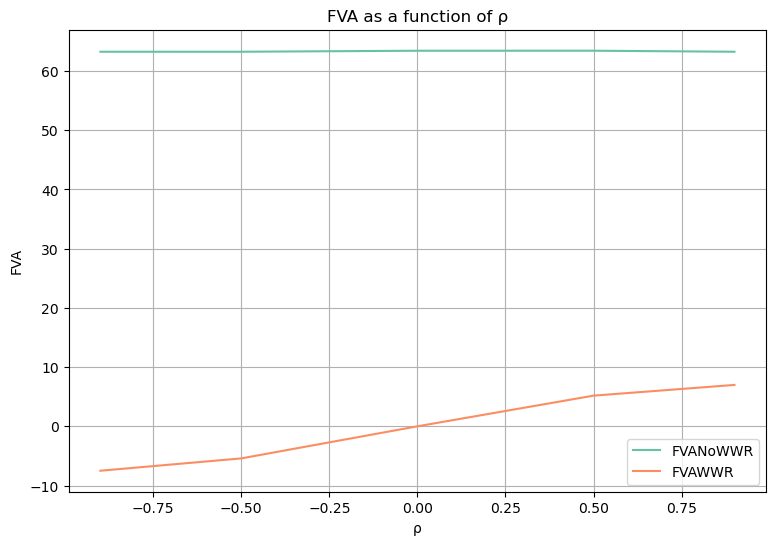

In [17]:
plt.figure(figsize=(9,6))

plt.plot(rhoDefault,FVANoWWRVec,label="FVANoWWR")
plt.plot(rhoDefault,FVAWWRVec,label="FVAWWR")
plt.title("FVA as a function of ρ")
plt.xlabel("ρ")
plt.ylabel("FVA")
plt.legend()
plt.grid()
plt.savefig("FVASwapWWRandNoWWR.png")


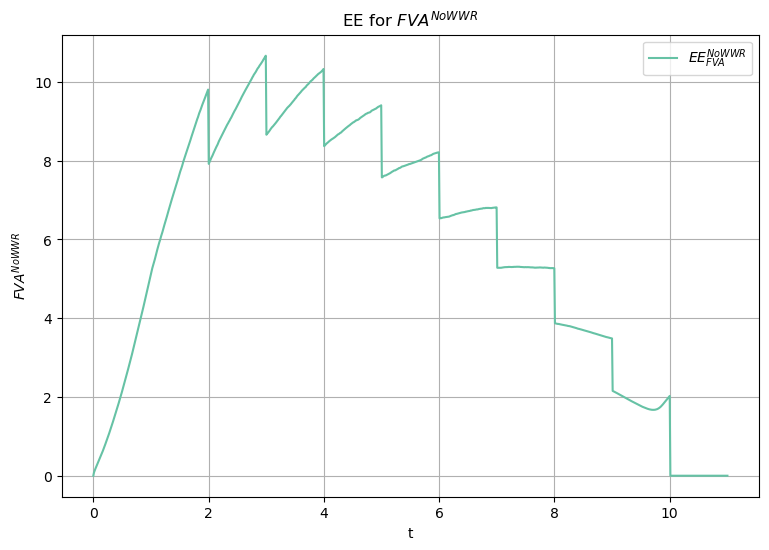

In [18]:
plt.figure(figsize=(9,6))

plt.plot(timeGrid,EENoWWR,label="$EE_{FVA}^{No WWR}$")
plt.plot(timeGrid,EENoWWR,label="$EE_{FVA}^{No WWR}$")

plt.xlabel("t")
plt.ylabel("$FVA^{No WWR}$")
plt.title("EE for $FVA^{No WWR}$")
plt.legend()
plt.grid()
plt.savefig("EEFVANoWWR.png")



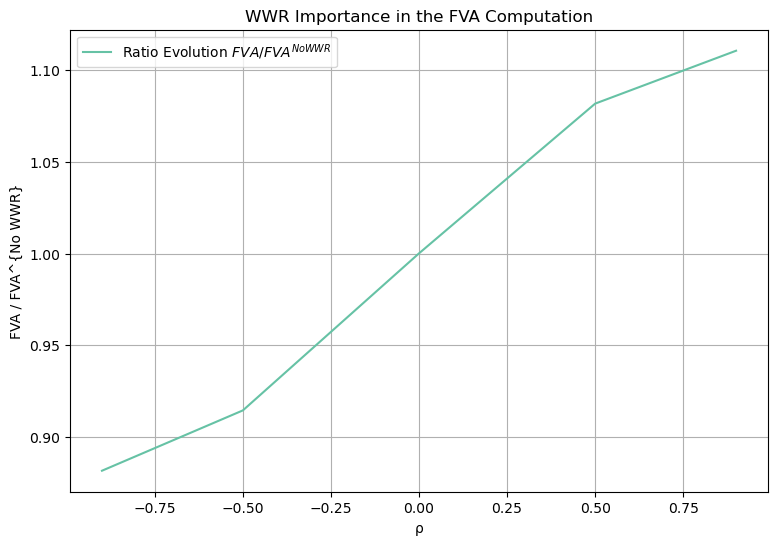

In [19]:
plt.figure(figsize=(9,6))
plt.plot(rhoDefault,FVARatioVec,label="Ratio Evolution $ FVA / FVA^{No WWR} $")
plt.legend()
plt.xlabel("ρ")
plt.ylabel("FVA / FVA^{No WWR}")
plt.title("WWR Importance in the FVA Computation")
plt.grid()
plt.savefig("RatioFVAWWRFVANoWWR.png")


In [20]:
print("FVA No WWR = "  + str( FVANoWWRVec))
print("FVA WWR = " + str(FVAWWRVec))
print("FVA " + str(FVAVec))

FVA No WWR = [63.25369159774541, 63.25272291054336, 63.42411896821902, 63.42658333543462, 63.25453447837923]
FVA WWR = [-7.488829549624806, -5.407791481979043, 0.009061585203923963, 5.187586485575527, 6.998041186253154]
FVA [55.76486204812063, 57.84493142856441, 63.433180553422936, 68.61416982101024, 70.25257566463253]


<h3> Case of a Deterministic spread including the modeling the counterparty of C : </h3>